In [0]:
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
from bs4 import BeautifulSoup
import requests
import pandas as pd
import re

In [2]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from textblob import TextBlob
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

page retrieved
page retrieved
page retrieved
page retrieved
page retrieved
page retrieved
page retrieved
page retrieved
page retrieved
page retrieved
page retrieved
page retrieved
page retrieved
page retrieved
page retrieved
page retrieved
page retrieved
page retrieved
page retrieved
page retrieved
page retrieved
page retrieved
page retrieved
  For a recent meetup I wanted to query the website     Unfortunately Power BI isn t compatible with the API this provider uses   They use a     Permanent redirect as the initial response  requiring an additional request  After a bit of digging Power Query only handles redirects up to       I have a suspicion this is  net problem  hence  may not be within control of the Power BI team to sort out     I used this blockage to test out using a Python script as a data source for Power BI     The Python web client has no problem handling     redirects  thankfully     I m running Python under a Conda environment so I had to set the options in Power BI to

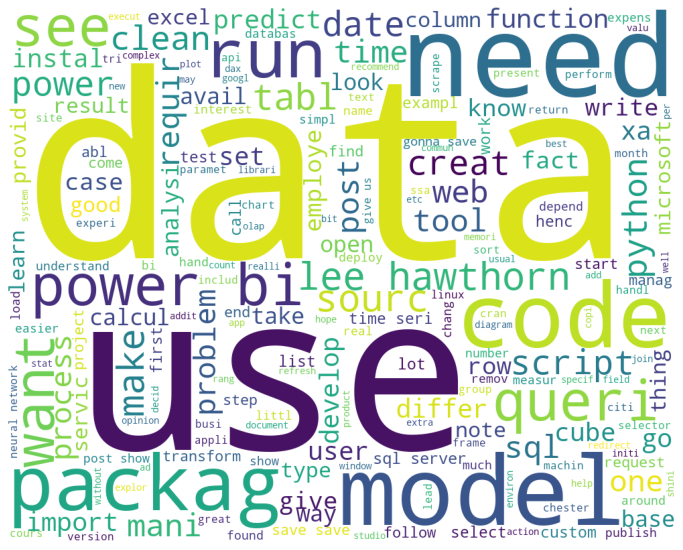

In [3]:
def con(url):
  page = requests.get(url)
  if page.status_code == 200:
    print('page retrieved')
    return page


def soup(page):
  try:
    soup = BeautifulSoup(page.content,'html.parser')
  except:
    raise ValueError('Parsing Error')
  return soup



def process_front(html):
  time = []
  link = []
  text = []
  base_domain = 'https://www.leehbi.com'

  for a in html.find_all('article'):

    time.append(a.find('time').contents[0])
    link.append(base_domain + a.find('a').get('href'))
    text.append(a.find('a').contents[0])

  l = list(zip(time,link,text))
  df = pd.DataFrame(l,columns=['Time','Link','Text'])
  return df


def process_post(html):
  t = []
  for a in html.find_all('p'):
    tx = str(a.contents[0])
    if tx[0] != '<':
      t.append(tx)

  return t


def get_post(url):
    r = con(url)
    html = soup(r)
    data = process_post(html)
    return data


def get_data(StartURL='https://www.leehbi.com/'):
    r = con(StartURL)
    html = soup(r)
    data = process_front(html)
    record = []
    for ind in data.index:
        l = data['Link'][ind]
        record.append(str(get_post(l)))

    raw = pd.DataFrame(record, columns=['Posts'])
    return raw  


def clean_data(df):
    """
    Takes in data frame  cleans data
    so we can carry out analysis
    remove stopwords, punctuation,
    lower case, html, emoticons.
    This will be done using a little Regex
    """

    # Do some text preprocessing
    stopword_list = stopwords.words('english')
    ps = PorterStemmer()
    lem = WordNetLemmatizer()

    df["clean_posts"] = None
    df['len'] = None
    for i in range(0, len(df['Posts'])):
        # get rid of anything that isn't a letter
        exclusion_list = ['[^a-zA-Z]', 'http']
        
        exclusions = '|'.join(exclusion_list)
        text = re.sub(exclusions, ' ', df['Posts'][i])
        print(text)
        text = text.lower()
        words = text.split()
        
        words = [word for word in words if not word in stopword_list]
        # only use stem of word
        words = [ps.stem(word) for word in words]
        # Lemmatise
        #words = [lem.lemmatize(word) for word in words]

        df['clean_posts'][i] = ' '.join(words)

    # Create column with data length
    df['len'] = np.array([len(posts) for posts in df['clean_posts']])

    return df



def sentiment(paragraph):
    """
    This function calculates sentiment
    from our base on cleaned paragraphs.
    Uses textblob to calculate polarity.
    Parameters:
    ----------------
    arg1: takes in a paragraph (row of dataframe)
    ----------------
    Returns:
            Sentiment:
            1 is Positive
            0 is Neutral
           -1 is Negative
    Adjust grouping of Polarity for your own use case
    """

    analysis = TextBlob(paragraph)
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1


def save_to_csv(df):
    """
    Save cleaned data to a csv for further
    analysis.
    Parameters:
    ----------------
    arg1: Pandas dataframe
    """
    try:
        df.to_csv("output.csv")
        print("\n")
        print("csv successfully saved. \n")

    except Error as e:
        print(e)


def word_cloud(df):
    plt.subplots(figsize=(12, 10))
    wordcloud = WordCloud(
        background_color='white',
        width=1000,
        height=800).generate(" ".join(df['clean_posts']))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.savefig('WordCloud.jpg')
    # plt.show()


def summarise(c):
    print(c)
    pos_posts = [post for index, post in enumerate(
        c["clean_posts"]) if c["Sentiment"][index] > 0]
    neg_posts = [post for index, post in enumerate(
        c["clean_posts"]) if c["Sentiment"][index] < 0]
    neu_posts = [post for index, post in enumerate(
        c["clean_posts"]) if c["Sentiment"][index] == 0]
    # Print results
    print("Percentage of positive posts: {}%".format(
        100*(len(pos_posts)/len(c['clean_posts']))))
    print("Percentage of negative posts: {}%".format(
        100*(len(neg_posts)/len(c['clean_posts']))))
    print("Percentage of neutral posts: {}%".format(
        100*(len(neu_posts)/len(c['clean_posts']))))


if __name__ == "__main__":
    text = get_data()
    c = clean_data(text)
    c['Sentiment'] = np.array([sentiment(x) for x in c['clean_posts']])
    word_cloud(c)
    save_to_csv(c)
    summarise(c)

